In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import numpy as np
import tensorflow as tf
from dsn.util.systems import V1Circuit
from dsn.train_dsn import train_dsn
from dsn.util.plot_util import assess_constraints, pairplot
import seaborn as sns
import pandas as pd
import warnings
import scipy
import time
warnings.filterwarnings("ignore")
import os

os.chdir('../../')

In [4]:
# set fixed params

fixed_params = {'W_VP':0.0, \
                'W_ES':0.0, \
                'W_PS':0.0, \
                'W_VS':0.0, \
                'W_SV':0.0, \
                'h_FFE':0.0, \
                'h_FFP':0.0, \
                'h_LATE':0.0, \
                'h_LATP':0.0, \
                'h_LATS':0.0, \
                'h_LATV':0.0, \
                'n':2.0, \
                's_0':30}

behavior_type = "difference"

c_vals=np.array([1.0])
s_vals=np.array([5])
r_vals=np.array([0.0, 1.0])

behavior = {'type':behavior_type, \
            'c_vals':c_vals, \
            's_vals':s_vals, \
            'r_vals':r_vals}

# set model options
model_opts = {"g_FF": "c", "g_LAT": "square", "g_RUN": "r"}
T = 100
dt = 0.005
init_conds = np.expand_dims(np.array([1.0, 1.0, 0.0, 0.0]), 1)

system = V1Circuit(fixed_params, behavior, model_opts, T, dt, init_conds)

{'type': 'difference', 'c_vals': array([1.]), 's_vals': array([5]), 'r_vals': array([0., 1.])}


In [78]:
np.random.seed(0)
M = 500
taus = [0.02]

num_taus = len(taus)

max_I = 2.0
#base_I = np.random.uniform(0.0, max_I, (M,))
base_I = 1.0*np.ones((M,))
b_E = base_I
b_P = base_I
b_S = base_I
b_V = base_I
#b_E = np.random.uniform(0.0, max_I, (M,))
#b_P = np.random.uniform(0.0, max_I, (M,))
#b_S = np.random.uniform(0.0, max_I, (M,))
#b_V = np.random.uniform(0.0, max_I, (M,))

#run_I = np.random.uniform(0.00, max_I, (M,))
run_I = 0.0*np.ones((M,))
runP_I = -0.1*np.ones((M,))
h_RUNE = run_I
h_RUNP = run_I + runP_I
h_RUNS = run_I
h_RUNV = run_I

max_WE = 10.0
# column 1
W_E = np.random.uniform(0.0, max_WE, (M,))
#W_EE = np.random.uniform(0.0, max_WE, (M,))
#W_PE = np.random.uniform(0.0, max_WE, (M,))

min_W = 0.0
max_W = 10.0
# column 2
W_EP = np.random.uniform(min_W, max_W, (M,))
W_PP = np.random.uniform(0.0, max_W, (M,))

tau = np.zeros((M,))

_Z = np.stack((W_E, W_EP, W_PP, \
               b_E, b_P, b_S, b_V, h_RUNE, h_RUNP, h_RUNS, h_RUNP, tau), axis=1)
_Z = np.expand_dims(_Z, 0)


In [79]:

num_params = system.D;
Z = tf.placeholder(dtype=tf.float64, shape=(1, None, num_params));

sess = tf.Session()
T_x = system.simulation_suff_stats(Z)
r_t = system.simulate(Z)

In [80]:
_T_xs = []
_r_ts = []
for i in range(num_taus):
    _tau = taus[i]
    _Z[0,:,-1] = _tau
    _T_x, _r_t = sess.run([T_x, r_t], {Z:_Z});
    _T_xs.append(_T_x)
    _r_ts.append(_r_t)


In [81]:
t = np.linspace(0.0, system.dt*(system.T-1), system.T)
black = 'k'
red =  [0.8, 0.0, 0.0]
blue = [0.0, 0.0, 0.8]

(100, 2, 500, 4, 1)
ISN coeff -0.15611580612291487
Z [1.43353287 5.30537215 4.90419908]


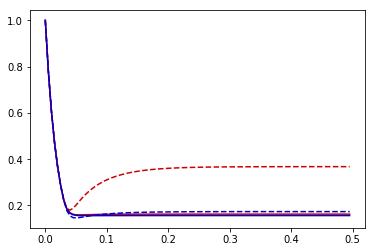

ISN coeff -0.03234895891273859
Z [1.28926298 8.1367865  8.53245976]


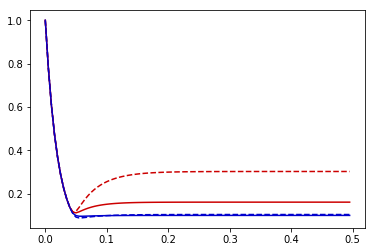

ISN coeff -0.4779990135969081
Z [1.31797862 6.72582311 7.54901104]


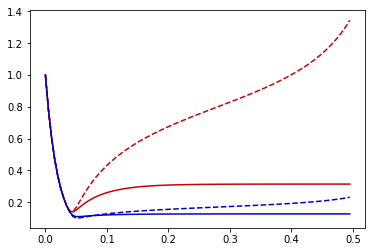

ISN coeff -1.4757776130426468
Z [1.35474064 4.32281481 9.5612316 ]


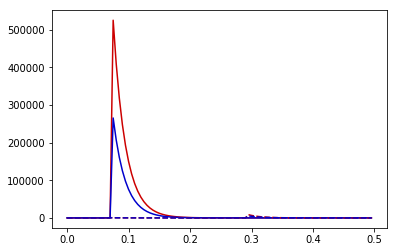

ISN coeff -0.02307963037752514
Z [1.44847759 9.66389971 9.71763076]


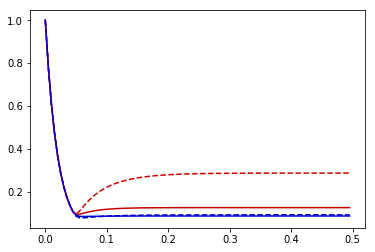

ISN coeff -0.825354784410862
Z [1.00293942 4.58503167 7.58193716]


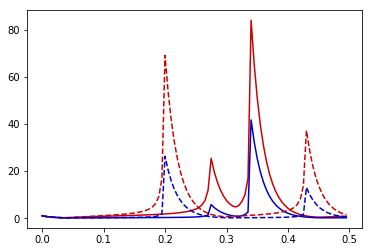

ISN coeff -2.5431678217126232
Z [0.97844484 3.91796939 6.60536177]


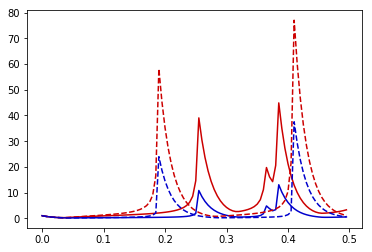

ISN coeff -1.099967772529292
Z [0.8110139  3.77406573 7.95456527]


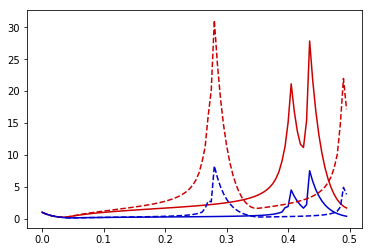

ISN coeff -0.042708382636103215
Z [0.79522083 2.88569958 3.96222745]


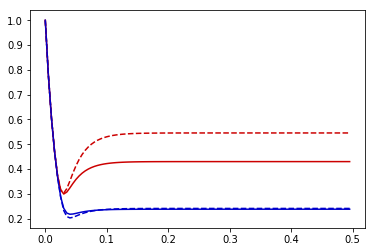

ISN coeff -0.11371585473368584
Z [0.9961493  2.11454796 2.01266766]


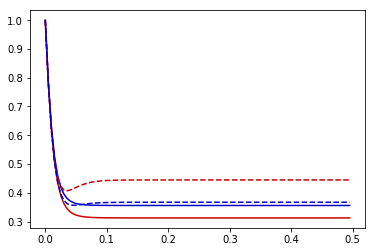

In [82]:
plot_ISNs = False

if plot_ISNs:
    plot_th = 1e3

    print(_r_ts[0].shape)
    betas = np.zeros((M,))
    r_ss_E = np.zeros((M,))
    for i in range(M):
        r_ss_E[i] = np.sqrt(_r_ts[0][-1,0,i,0,0])
        betas[i] = 1 - 2*r_ss_E[i]*W_E[i]
        if (_r_ts[0][-1,0,i,0,0] > plot_th or _r_ts[0][-1,1,i,0,0] > plot_th or betas[i] > 0.0):
            continue
        print('ISN coeff', betas[i])
        print('Z', _Z[0,i,:3])
        plt.figure()
        plt.plot(t, _r_ts[0][:,0,i,0,0], c=red)
        plt.plot(t, _r_ts[0][:,0,i,1,0], c=blue)
        plt.plot(t, _r_ts[0][:,1,i,0,0], '--', c=red)
        plt.plot(t, _r_ts[0][:,1,i,1,0], '--', c=blue)
        plt.show()

In [83]:
stable_inds = np.logical_and(r_ss_E < 100.0, r_ss_E > -0.001)

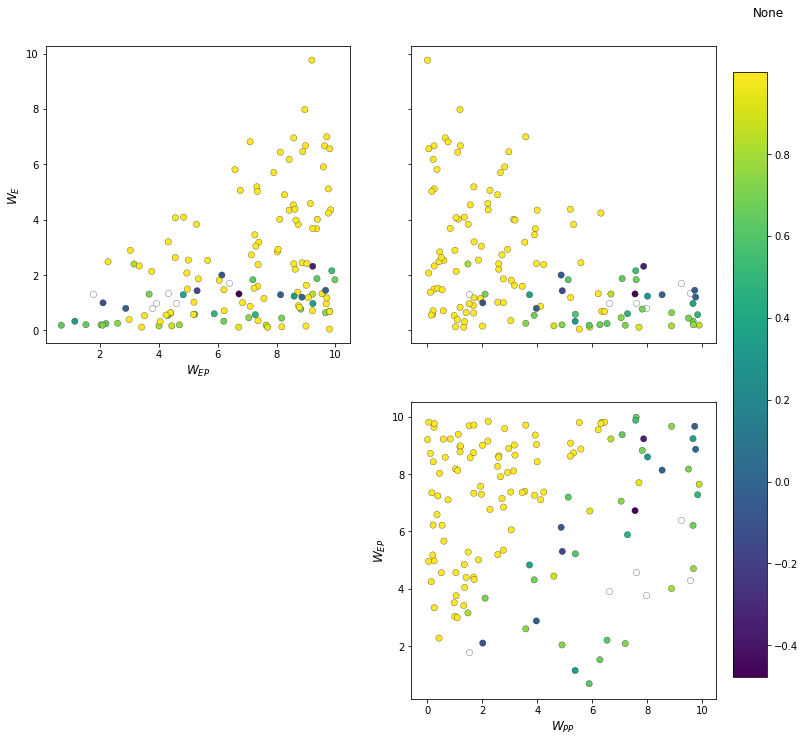

In [84]:
fig = pairplot(_Z[0,stable_inds], range(3), system.z_labels, c=betas[stable_inds])